# Obtain Pedestrian Data and Sensor Location Data

In [1]:
# Set up
import pandas as pd
from sodapy import Socrata
import requests
from pprint import pprint
import gmaps
import os
import json

from api_keys_tokens import MyAppToken
from api_keys_tokens import google_key

### Get All The Pedestrian Data

In [9]:
# Pedestrian Counting System - Monthly (counts per hour) Example

# Resource - https://dev.socrata.com/foundry/data.melbourne.vic.gov.au/b2ak-trbp

client = Socrata("data.melbourne.vic.gov.au", MyAppToken )
pedestrian_count_dataset_id = "b2ak-trbp"
# First 2000 records
pedestrian_count_request = client.get(pedestrian_count_dataset_id, limit=4000000)
# Convert to pandas DataFrame
pedestrian_count_df = pd.DataFrame.from_records(pedestrian_count_request)

In [9]:
# Send result to a csv file
pedestrian_count_df.to_csv("Melbourne City Council Data/all_pedestrian_data.csv",encoding='utf-8', index=False)

### Get all the sensor location data

In [11]:
# Pedestrian Counting System - Sensor Locations
# Resource - https://dev.socrata.com/foundry/data.melbourne.vic.gov.au/h57g-5234
client = Socrata("data.melbourne.vic.gov.au", MyAppToken )

sensor_location_id = "h57g-5234"

# First 2000 records - Pedestrian Counting System - Monthly (counts per hour) Example
sensor_location_id_request = client.get(sensor_location_id, limit=100)
# Convert to pandas DataFrame
sensor_location_df = pd.DataFrame.from_records(sensor_location_id_request)

In [12]:
# send to a csv file
sensor_location_df.to_csv("Melbourne City Council Data/all_sensor_location_data.csv",encoding='utf-8', index=False)

### Get only pedestrian data from August 2019 to August 2021

In [31]:
data = pd.read_csv("Melbourne City Council Data/all_pedestrian_data.csv")

# Find only the data between the beginning of August 2019 and the end of August 2021
filtered_df = data.loc[(data['date_time'] >= '2019-08-01') & (data['date_time'] < '2021-09-01')].sort_values(["id"])

# Send result to a DataFile
filtered_df.to_csv("Melbourne City Council Data/filtered_pedestrian_data.csv",encoding='utf-8', index=False)

### Find the Postcode for Each Sensor (using Google API Mapping)

In [10]:
# Get the data
data = pd.read_csv("Melbourne City Council Data/filtered_pedestrian_data.csv")
sensor_data = pd.read_csv("Melbourne City Council Data/all_sensor_location_data.csv")

# Add a "Postcode" column to the DataFrame.
sensor_data["Address"] = ""
# base url
base_url = "https://maps.googleapis.com/maps/api/geocode/json?"

# use iterrows to iterate through pandas dataframe
for index, row in sensor_data.iterrows():
    
    # Set the parameters of the searc
    params = {
    "latlng": f"{sensor_data.loc[index, 'latitude']}, {sensor_data.loc[index, 'longitude']}",
    "key": google_key
    }
    
    # assemble url and make API request
    try: 
        response = requests.get(base_url, params=params).json()
        # Get the postcode
        address = response["results"][0]["formatted_address"]
        # Assign it to the hotel DataFrame
        sensor_data.loc[index, 'Address'] = address
        # Log the result
        print(address)
        
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")
    
    print("-----------------------------------------------------")


380A Elizabeth St, Melbourne VIC 3000, Australia
-----------------------------------------------------
150 Swanston St, Melbourne VIC 3000, Australia
-----------------------------------------------------
418 Swanston St, Melbourne VIC 3000, Australia
-----------------------------------------------------
Unnamed Road, Melbourne VIC 3004, Australia
-----------------------------------------------------
123 Flinders St, Melbourne VIC 3000, Australia
-----------------------------------------------------
252 La Trobe St, Melbourne VIC 3000, Australia
-----------------------------------------------------
231 Bourke Street Mall, Melbourne VIC 3000, Australia
-----------------------------------------------------
Sandridge Bridge, 1 Southbank Blvd, Southbank VIC 3006, Australia
-----------------------------------------------------
703/37 Swanston St, Melbourne VIC 3000, Australia
-----------------------------------------------------
2 Clarendon St, South Wharf VIC 3006, Australia
---------------

In [121]:
sensor_data["Postcode"] = sensor_data["Address"].str.slice(start=-15,stop=-11)

In [123]:
sensor_data.to_csv("Melbourne City Council Data/sensor_data_postcode.csv")

### Find Postcodes in Pedestrian DataSet

In [23]:
sensor_data_postcode = pd.read_csv("Melbourne City Council Data/sensor_data_postcode.csv")
postcode_list = sensor_data_postcode["Postcode"].unique()

### Show sensor locations on Google Maps

In [7]:
# Configure gmaps
gmaps.configure(api_key = google_key)
fig = gmaps.figure()

# Using the template add the sensor location marks to the figure
info_box_template = """
<dl>
<dt>Sensor Name</dt><dd>{sensor_name}</dd>
<dt>Sensor Address</dt><dd>{Address}</dd>
<dt>Postcode</dt><dd>{Postcode}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
sensor_data_info = [info_box_template.format(**row) for index, row in sensor_data_postcode.iterrows()]

In [8]:
# Add Postcodes
with open('Postcodes.geojson') as f:
    geometry = json.load(f)
    
fig = gmaps.figure()
geojson_layer = gmaps.geojson_layer(geojson=geometry,fill_color="yellow",fill_opacity=0.2,stroke_color="blue")
fig.add_layer(geojson_layer)

# Add sensor locations
sensor_locations = sensor_data_postcode[["latitude", "longitude"]]
# Add the sensor markers to the postcode map
markers = gmaps.marker_layer(sensor_locations, info_box_content = sensor_data_info)
fig.add_layer(markers)

# Display the improved heat map
fig

Figure(layout=FigureLayout(height='420px'))

### Obtain and filter jobkeeper data

In [2]:
# Get the data
first_phase = pd.read_excel("jobkeeper data/jobkeeperdata.xlsx", sheet_name='First Phase',header=1, usecols="A:G")
extension_quarter1 = pd.read_excel("jobkeeper data/jobkeeperdata.xlsx", sheet_name='Extension - First Quarter',header=1, usecols="A:D")
extension_quarter2 = pd.read_excel("jobkeeper data/jobkeeperdata.xlsx", sheet_name='Extension - Second Quarter',header=1, usecols="A:D")

# Save all of them to csv sheets
first_phase.to_csv("jkd_first_phase.csv", index=False)
extension_quarter1.to_csv("jobkeeper data/jkd_extension_quarter1.csv", index=False)
extension_quarter2.to_csv("jobkeeper data/jkd_extension_quarter2.csv", index=False)

In [3]:
# Get the data
first_phase_data = pd.read_csv("jobkeeper data/jkd_first_phase.csv")
first_extension_data = pd.read_csv("jobkeeper data/jkd_extension_quarter1.csv")
second_extension_data = pd.read_csv("jobkeeper data/jkd_extension_quarter2.csv")

# Convert the Postcodes of each dataFrame to strings
first_phase_data['Postcode'] = pd.Series(first_phase_data['Postcode'], dtype=pd.StringDtype())
first_extension_data['Postcode'] = pd.Series(first_extension_data['Postcode'], dtype=pd.StringDtype())
second_extension_data['Postcode'] = pd.Series(second_extension_data['Postcode'], dtype=pd.StringDtype())

# Cut the postcodes to the right length
first_phase_data['Postcode'] = first_phase_data['Postcode'].str.slice(start=2)
first_extension_data['Postcode'] = first_extension_data['Postcode'].str.slice(start=2)
second_extension_data['Postcode'] = second_extension_data['Postcode'].str.slice(start=2)

In [5]:
# Get all the first phase data
MCC_first_phase_data = first_phase_data.loc[(first_phase_data["Postcode"] == "3000") |
                                            (first_phase_data["Postcode"] == "3004") |
                                            (first_phase_data["Postcode"] == "3006") |
                                            (first_phase_data["Postcode"] == "3008") |
                                            (first_phase_data["Postcode"] == "3010") |
                                            (first_phase_data["Postcode"] == "3031") |
                                            (first_phase_data["Postcode"] == "3051") |
                                            (first_phase_data["Postcode"] == "3052") |
                                            (first_phase_data["Postcode"] == "3053")
                                           ]

# Get all the first extension data
MCC_first_extension_data = first_extension_data.loc[
                                            (first_extension_data["Postcode"] == "3000") |
                                            (first_extension_data["Postcode"] == "3004") |
                                            (first_extension_data["Postcode"] == "3006") |
                                            (first_extension_data["Postcode"] == "3008") |
                                            (first_extension_data["Postcode"] == "3010") |
                                            (first_extension_data["Postcode"] == "3031") |
                                            (first_extension_data["Postcode"] == "3051") |
                                            (first_extension_data["Postcode"] == "3052") |
                                            (first_extension_data["Postcode"] == "3053")
                                           ]

# # Get all the second extension data
MCC_second_extension_data = second_extension_data.loc[(second_extension_data["Postcode"] == "3000") |
                                            (second_extension_data["Postcode"] == "3004") |
                                            (second_extension_data["Postcode"] == "3006") |
                                            (second_extension_data["Postcode"] == "3008") |
                                            (second_extension_data["Postcode"] == "3010") |
                                            (second_extension_data["Postcode"] == "3031") |
                                            (second_extension_data["Postcode"] == "3051") |
                                            (second_extension_data["Postcode"] == "3052") |
                                            (second_extension_data["Postcode"] == "3053")
                                           ]


In [6]:
MCC_first_phase_data

,Postcode,April Application Count,May Application Count,June Application Count,July Application Count,August Application Count,September Application Count
649,3000,6850,7135,7242,7347,7555,7508
653,3004,1283,1348,1363,1401,1460,1454
655,3006,963,1010,1022,1042,1083,1072
656,3008,902,929,949,952,989,988
657,3010,5,5,6,6,6,6
676,3031,722,767,786,806,817,816
694,3051,880,911,933,948,974,979
695,3052,222,238,241,245,250,250
696,3053,827,862,877,907,932,913


In [7]:
MCC_first_extension_data

,Postcode,October Application Count,November Application Count,December Application Count
629,3000,5493,5445,5364
633,3004,990,993,975
634,3006,801,786,777
635,3008,752,744,730
636,3010,5,5,5
655,3031,619,617,607
673,3051,748,738,723
674,3052,176,171,170
675,3053,710,695,681


In [8]:
MCC_second_extension_data

,Postcode,January Application Count,February Application Count,March Application Count
605,3000,4346,4315,4165
609,3004,771,776,749
610,3006,637,623,590
611,3008,602,594,576
612,3010,6,6,6
631,3031,491,481,459
649,3051,558,554,538
650,3052,144,140,137
651,3053,509,502,481


In [315]:
## Merge the data frames
application_counts = MCC_first_phase_data.merge(MCC_first_extension_data, on="Postcode").merge(MCC_second_extension_data, on="Postcode")

application_counts = application_counts.rename(columns={"April Application Count": "April 2020",
                                                       "May Application Count": "May 2020",
                                                        "June Application Count": "June 2020",
                                                        "July Application Count": "July 2020",
                                                        "August Application Count": "August 2020",
                                                        "September Application Count": "September 2020",
                                                        "October Application Count": "October 2020",
                                                        "November Application Count": "November 2020",
                                                        "December Application Count": "Decemeber 2020",
                                                        "January Application Count": "Jananuary 2021",
                                                        "February Application Count": "February 2021",
                                                        "March Application Count": "March 2021"
                                                       })

application_counts

,Postcode,April 2020,May 2020,June 2020,July 2020,August 2020,September 2020,October 2020,November 2020,Decemeber 2020,Jananuary 2021,February 2021,March 2021
0,3000,6850,7135,7242,7347,7555,7508,5493,5445,5364,4346,4315,4165
1,3004,1283,1348,1363,1401,1460,1454,990,993,975,771,776,749
2,3006,963,1010,1022,1042,1083,1072,801,786,777,637,623,590
3,3008,902,929,949,952,989,988,752,744,730,602,594,576
4,3010,5,5,6,6,6,6,5,5,5,6,6,6
5,3031,722,767,786,806,817,816,619,617,607,491,481,459
6,3051,880,911,933,948,974,979,748,738,723,558,554,538
7,3052,222,238,241,245,250,250,176,171,170,144,140,137
8,3053,827,862,877,907,932,913,710,695,681,509,502,481


In [318]:
# Save the file to a csv
application_counts.to_csv("jobkeeper data/application_counts.csv", index=False)

In [307]:
#  Get summarised pedestrian location data
pedestrian_location = pd.read_excel("pedestrian data per location.xlsx", sheet_name='Sheet1',header=0,dtype=pd.StringDtype())

# Transpose the data
pedestrian_location_new = pedestrian_location.T
pedestrian_location_new.columns = pedestrian_location_new.iloc[0]
pedestrian_location_new = pedestrian_location_new.drop("Month")

pedestrian_location_new = pedestrian_location_new.reset_index()

pedestrian_location_new = pedestrian_location_new.rename(columns={"2019-08-01 00:00:00": "Aug 19", "2019-09-01 00:00:00": "Sep 19",
                                                                  "2019-10-01 00:00:00": "Oct 19", "2019-11-01 00:00:00": "Nov 19",
                                                                  "2019-12-01 00:00:00": "Dec 19",
                                                                  "2020-01-01 00:00:00": "Jan 20", "2020-02-01 00:00:00": "Feb 20",
                                                                  "2020-03-01 00:00:00": "Mar 20", "2020-04-01 00:00:00": "Apr 20",
                                                                  "2020-05-01 00:00:00": "May 20", "2020-06-01 00:00:00": "Jun 20",
                                                                  "2020-07-01 00:00:00": "Jul 20", "2020-08-01 00:00:00": "Aug 20",
                                                                  "2020-09-01 00:00:00": "Sep 20", "2020-10-01 00:00:00": "Oct 20",
                                                                  "2020-11-01 00:00:00": "Nov 20", "2020-12-01 00:00:00": "Dec 20",
                                                                  "2021-01-01 00:00:00": "Jan 21", "2021-02-01 00:00:00": "Feb 21",
                                                                  "2021-03-01 00:00:00": "Mar 21", "2021-04-01 00:00:00": "Apr 21",
                                                                  "2021-05-01 00:00:00": "May 21", "2021-06-01 00:00:00": "Jun 21",
                                                                  "2021-07-01 00:00:00": "Jul 21", "2021-08-01 00:00:00": "Aug 21",
                                                                 "index": "sensor_description"})

pedestrian_location_new = pedestrian_location_new.rename_axis(None, axis=1)

# Merge it with the other sensor data.
sensor_data = pd.read_csv("Melbourne City Council Data/sensor_data_postcode.csv")

pedestrian_location_sensor_data = pedestrian_location_new.merge(sensor_data, on="sensor_description")

# pedestrian_location_sensor_data.shape

# sensor_data["status"].value_counts()

pedestrian_location_new.shape


(47, 26)

### Try to sum up the pedestrian values yourself

In [130]:
pedestrian_data = pd.read_csv("Melbourne City Council Data/filtered_pedestrian_data.csv")

# Sum the data by year, month, and sensor id
summed_pedestrian_data = pedestrian_data.groupby(["year","month","sensor_id"]).sum("hourly_counts")
summed_pedestrian_data = summed_pedestrian_data["hourly_counts"].reset_index()

summed_pedestrian_data["month-year"] = summed_pedestrian_data["month"].astype(str) + " " + summed_pedestrian_data["year"].astype(str)
summed_pedestrian_data = summed_pedestrian_data.drop(["year","month"], axis=1)
# rename hourly count column
summed_pedestrian_data = summed_pedestrian_data.rename(columns={"hourly_counts": "monthly_count"})

# Trans
#summed_pedestrian_data = summed_pedestrian_data.T

#summed_pedestrian_data = summed_pedestrian_data.set_index("sensor_id")
ped_df = summed_pedestrian_data.pivot(index="sensor_id", columns="month-year", values="monthly_count")
ped_df

month-year,April 2020,April 2021,August 2019,August 2020,August 2021,December 2019,December 2020,February 2020,February 2021,January 2020,...,March 2020,March 2021,May 2020,May 2021,November 2019,November 2020,October 2019,October 2020,September 2019,September 2020
sensor_id,,,,,,,,,,,,,,,,,,,,,
1,118072.0,612164.0,838069.0,70551.0,156531.0,1192463.0,714656.0,799619.0,354240.0,892048.0,...,560956.0,523660.0,269797.0,NaN,1037267.0,498611.0,1028681.0,155212.0,943758.0,71264.0
2,90403.0,361785.0,641791.0,55197.0,80548.0,927155.0,512225.0,576590.0,215505.0,668884.0,...,413673.0,315709.0,166652.0,NaN,744945.0,299204.0,477010.0,99598.0,643780.0,53963.0
3,127245.0,337429.0,981893.0,92864.0,105047.0,911297.0,351662.0,741496.0,104829.0,761665.0,...,560572.0,210303.0,221395.0,280760.0,901523.0,425215.0,919197.0,200440.0,869674.0,114151.0
4,130659.0,743653.0,1064689.0,97813.0,213065.0,1244392.0,796734.0,905988.0,456419.0,1030896.0,...,634135.0,650570.0,245937.0,611918.0,1074747.0,490630.0,1047186.0,198010.0,971314.0,112765.0
5,98688.0,759926.0,963378.0,91977.0,178661.0,1068849.0,731645.0,942341.0,515746.0,1247383.0,...,595265.0,660726.0,156405.0,NaN,673975.0,364502.0,1028104.0,184081.0,925437.0,112820.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,NaN,9753.0,NaN,NaN,NaN,NaN,58787.0,NaN,64887.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,NaN,32005.0,NaN,NaN,15795.0,NaN,NaN,NaN,23649.0,NaN,...,NaN,30935.0,NaN,31189.0,NaN,NaN,NaN,NaN,NaN,NaN
76,NaN,41175.0,NaN,NaN,42283.0,NaN,NaN,NaN,NaN,NaN,...,NaN,45657.0,NaN,45442.0,NaN,NaN,NaN,NaN,NaN,NaN


### Clean the data

In [132]:
# Count NA values in each column
ped_df.isnull().sum(axis=1)

#Remove all rows with NA values in them
ped_df = df.dropna()
# Remove the extra columns
ped_df = df.reset_index()
ped_df = df.rename_axis(None, axis=1)
#ped_df = df.drop(columns=["level_0","index"])

In [133]:
ped_df

,sensor_id,April 2020,April 2021,August 2019,August 2020,August 2021,December 2019,December 2020,February 2020,February 2021,...,March 2020,March 2021,May 2020,May 2021,November 2019,November 2020,October 2019,October 2020,September 2019,September 2020
0,3,127245.0,337429.0,981893.0,92864.0,105047.0,911297.0,351662.0,741496.0,104829.0,...,560572.0,210303.0,221395.0,280760.0,901523.0,425215.0,919197.0,200440.0,869674.0,114151.0
1,4,130659.0,743653.0,1064689.0,97813.0,213065.0,1244392.0,796734.0,905988.0,456419.0,...,634135.0,650570.0,245937.0,611918.0,1074747.0,490630.0,1047186.0,198010.0,971314.0,112765.0
2,8,63684.0,112938.0,145010.0,68999.0,87220.0,146969.0,106220.0,135257.0,91493.0,...,108630.0,85345.0,86192.0,114358.0,137905.0,61169.0,54501.0,91349.0,140774.0,82252.0
3,11,26293.0,38862.0,31232.0,23613.0,28847.0,54072.0,42354.0,37750.0,30952.0,...,33571.0,31651.0,27802.0,27389.0,38037.0,38577.0,39842.0,32443.0,33821.0,31762.0
4,27,34092.0,66367.0,110089.0,32909.0,52907.0,86444.0,64809.0,64092.0,51909.0,...,44171.0,63883.0,48565.0,68715.0,91938.0,53226.0,116007.0,43482.0,105748.0,37112.0
5,28,75387.0,563047.0,815103.0,69231.0,101841.0,732686.0,303045.0,701412.0,317626.0,...,420725.0,458441.0,104748.0,411164.0,774709.0,167861.0,784497.0,107007.0,772680.0,81766.0
6,29,41299.0,121408.0,245551.0,34641.0,54388.0,279113.0,45554.0,190047.0,23016.0,...,244703.0,150365.0,63847.0,96813.0,323731.0,75898.0,306072.0,57310.0,239907.0,45078.0
7,30,47556.0,262827.0,409135.0,35315.0,61402.0,367248.0,220907.0,299653.0,156380.0,...,215228.0,220463.0,66293.0,213839.0,388344.0,158236.0,430807.0,63195.0,390685.0,35982.0
8,31,42345.0,126872.0,165319.0,40863.0,42118.0,187154.0,159977.0,161819.0,96964.0,...,125182.0,120504.0,59672.0,100769.0,186602.0,181951.0,185840.0,74495.0,165207.0,45843.0
9,34,20090.0,45860.0,136747.0,15199.0,24083.0,94563.0,25311.0,106629.0,28641.0,...,70805.0,41380.0,25924.0,49260.0,100883.0,20131.0,110627.0,19772.0,112127.0,18816.0


In [357]:
# Get sensor location data
sensor_data = pd.read_csv("Melbourne City Council Data/sensor_data_postcode.csv")

# Merge it with the other sensor data.
pedestrian_location_sensor_data = ped_df.merge(sensor_data, on="sensor_id")
pedestrian_location_sensor_data

# Remove unwanted columns
pedestrian_location_sensor_data = pedestrian_location_sensor_data.drop(columns=["installation_date","location","note"])
del pedestrian_location_sensor_data["Unnamed: 0"]

pedestrian_location_sensor_data

# Save to csv file
pedestrian_location_sensor_data.to_csv("Melbourne City Council Data/pedestrian_location_sensor_data.csv", index=False)

### Find Pedestrian Activity by Postcode per month

In [212]:
# Sum the pedestrian traffic by postcode
pedestrian_location_sensor_data_sum = pedestrian_location_sensor_data.groupby("Postcode").sum()

# Get rid of unwanted columns
pedestrian_location_sensor_data_sum = pedestrian_location_sensor_data_sum.drop(columns=["sensor_id","latitude","longitude"])

pedestrian_location_sensor_data_sum

,April 2020,April 2021,August 2019,August 2020,August 2021,December 2019,December 2020,February 2020,February 2021,January 2020,...,March 2020,March 2021,May 2020,May 2021,November 2019,November 2020,October 2019,October 2020,September 2019,September 2020
Postcode,,,,,,,,,,,,,,,,,,,,,
3000,1024479.0,3915301.0,6933852.0,781393.0,1313082.0,6661593.0,3476653.0,5735095.0,2316395.0,5884819.0,...,4237348.0,3480340.0,1622996.0,3454668.0,6325968.0,2618461.0,6855644.0,1285169.0,6287155.0,882223.0
3004,109479.0,629414.0,925192.0,102140.0,154748.0,819130.0,367854.0,765504.0,369535.0,994735.0,...,464896.0,522324.0,153313.0,479879.0,866647.0,221087.0,900504.0,150489.0,878428.0,118878.0
3006,41299.0,121408.0,245551.0,34641.0,54388.0,279113.0,45554.0,190047.0,23016.0,279641.0,...,244703.0,150365.0,63847.0,96813.0,323731.0,75898.0,306072.0,57310.0,239907.0,45078.0
3008,114180.0,521195.0,1034717.0,115428.0,182531.0,582828.0,227975.0,814956.0,162129.0,620898.0,...,478396.0,336060.0,151740.0,468822.0,721514.0,158432.0,595880.0,151652.0,659475.0,133627.0
3010,26338.0,112208.0,356111.0,26930.0,49191.0,145925.0,59427.0,187187.0,73307.0,139888.0,...,222884.0,142908.0,36920.0,117954.0,210204.0,71125.0,263562.0,48637.0,274422.0,31362.0
3052,11460.0,85887.0,217817.0,13801.0,26917.0,50258.0,22905.0,99105.0,38200.0,64079.0,...,143196.0,101222.0,20132.0,105440.0,85326.0,27380.0,134082.0,22574.0,149689.0,17839.0
3053,117199.0,405995.0,537900.0,108934.0,158427.0,563859.0,456104.0,503761.0,295097.0,537851.0,...,395306.0,392560.0,174678.0,351161.0,574188.0,428256.0,579677.0,196227.0,525270.0,132336.0


In [340]:
import matplotlib as plt
import scipy.stats as st


# pedestrian_location_sensor_data_sum = pedestrian_location_sensor_data_sum.T
# pedestrian_location_sensor_data_sum = pedestrian_location_sensor_data_sum.reset_index()

# Sort the values of the columns
pedestrian_location_sensor_data_sum = pedestrian_location_sensor_data_sum[['August 2019', 'September 2019',
                                                                           'October 2019', 'November 2019', 'December 2019',
                                                                           'January 2020', 'February 2020', 'March 2020',
                                                                           'April 2020', 'May 2020', 'June 2020',
                                                                           'July 2020', 'August 2020', 'September 2020',
                                                                           'October 2020', 'November 2020', 'December 2020', 
                                                                           'January 2021','February 2021', 'March 2021',
                                                                           'April 2021', 'May 2021', 'June 2021',
                                                                           'July 2021', 'August 2021'
                                                                          ]]
# Transpose the data for mapping
df = pedestrian_location_sensor_data_sum.T

# Fix the names and columns
df = df.reset_index()
df = df.rename(columns={"index": "Date"})
# Fix the name of the index
df = df.rename_axis(None, axis=1)
df

df.to_csv("Melbourne City Council Data/Pedestrian_Activity_by_Postcode_per_month.csv", index=False)

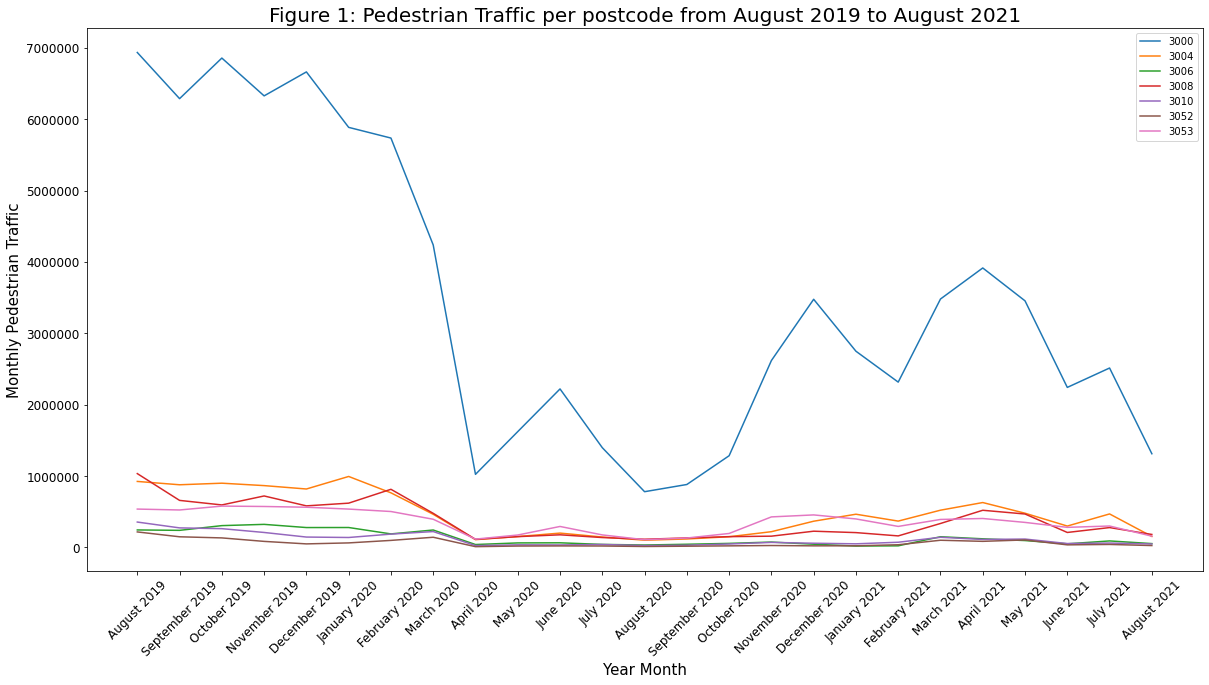

In [356]:
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter

tick_spacing = 1

# Plot the data
df_line_plot = df.plot(x="Date",figsize = (20,10))

# Improve figure layout
df_line_plot.set_xlabel(xlabel = "Year Month", size = 15)
df_line_plot.set_ylabel(ylabel = "Monthly Pedestrian Traffic", size = 15)
df_line_plot.set_title(("Figure 1: Pedestrian Traffic per postcode from August 2019 to August 2021") , size = 20)
df_line_plot.xaxis.set_tick_params(labelsize = 12, rotation = 45)
df_line_plot.yaxis.set_tick_params(labelsize = 12)

date_list = ['August 2019', 'September 2019','October 2019', 'November 2019', 'December 2019',
             'January 2020', 'February 2020', 'March 2020', 'April 2020', 'May 2020', 'June 2020',
             'July 2020', 'August 2020', 'September 2020', 'October 2020', 'November 2020', 'December 2020', 
             'January 2021','February 2021', 'March 2021', 'April 2021', 'May 2021', 'June 2021',
             'July 2021', 'August 2021']

# Fix tick values
df_line_plot.ticklabel_format(axis='y', style='plain')

df_line_plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

positions = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]

df_line_plot.xaxis.set_major_locator(ticker.FixedLocator(positions))
df_line_plot.xaxis.set_major_formatter(ticker.FixedFormatter(date_list))

plt.pyplot.savefig("James Plots/Figure 1", dpi=400)

### Jobkeeper claims per postocode per month

In [333]:
# Read the file from a csv
applications_counts_data = pd.read_csv("jobkeeper data/application_counts.csv")

# Get set the index
applications_counts_data = applications_counts_data.set_index("Postcode")

# Transpose data
applications_counts_data = applications_counts_data.T.reset_index()

# # Fix headers
# applications_counts_data = applications_counts_data.rename(columns=application_counts.iloc[0])
applications_counts_data = applications_counts_data.rename_axis(None, axis=1)
applications_counts_data = applications_counts_data.rename(columns={"index":"date"})

#applications_counts_data

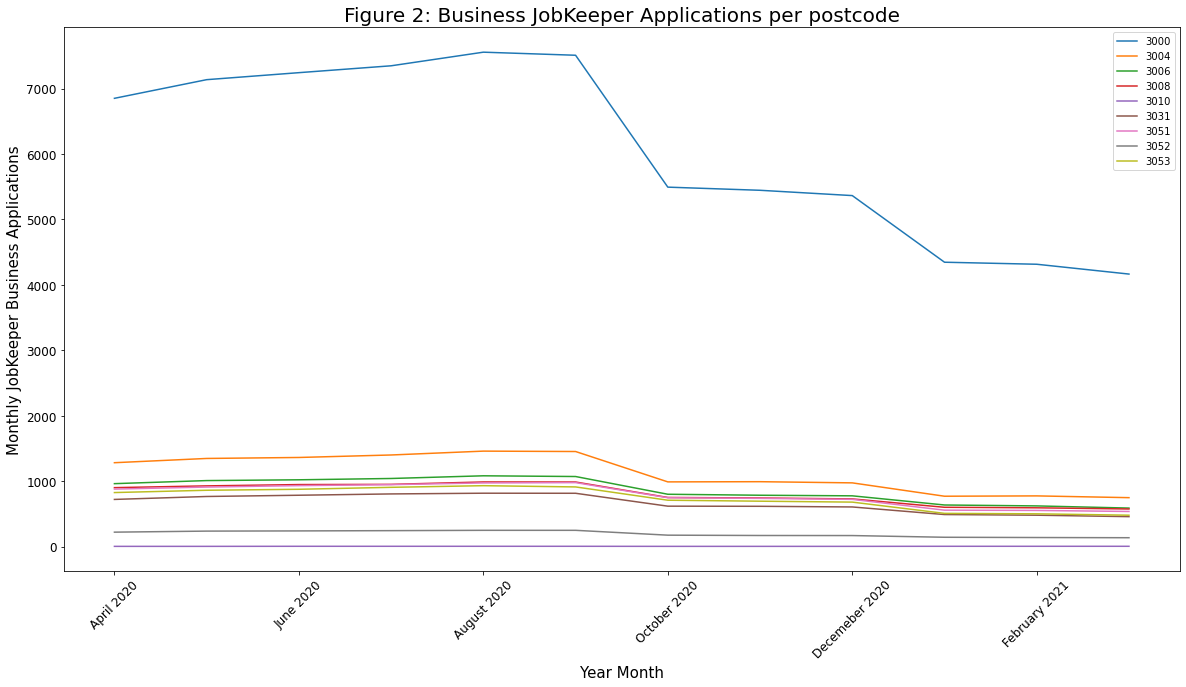

In [355]:
# Plot the data
app_count_plot = applications_counts_data.plot(x="date",figsize = (20,10))

# Improve figure layout
app_count_plot.set_xlabel(xlabel = "Year Month", size = 15)
app_count_plot.set_ylabel(ylabel = "Monthly JobKeeper Business Applications", size = 15)
app_count_plot.set_title(("Figure 2: Business JobKeeper Applications per postcode") , size = 20)
app_count_plot.xaxis.set_tick_params(labelsize = 12, rotation = 45)
app_count_plot.yaxis.set_tick_params(labelsize = 12)

plt.pyplot.savefig("James Plots/Figure 2", dpi=400)

### Pedestrian Count during the JobKeeper Period

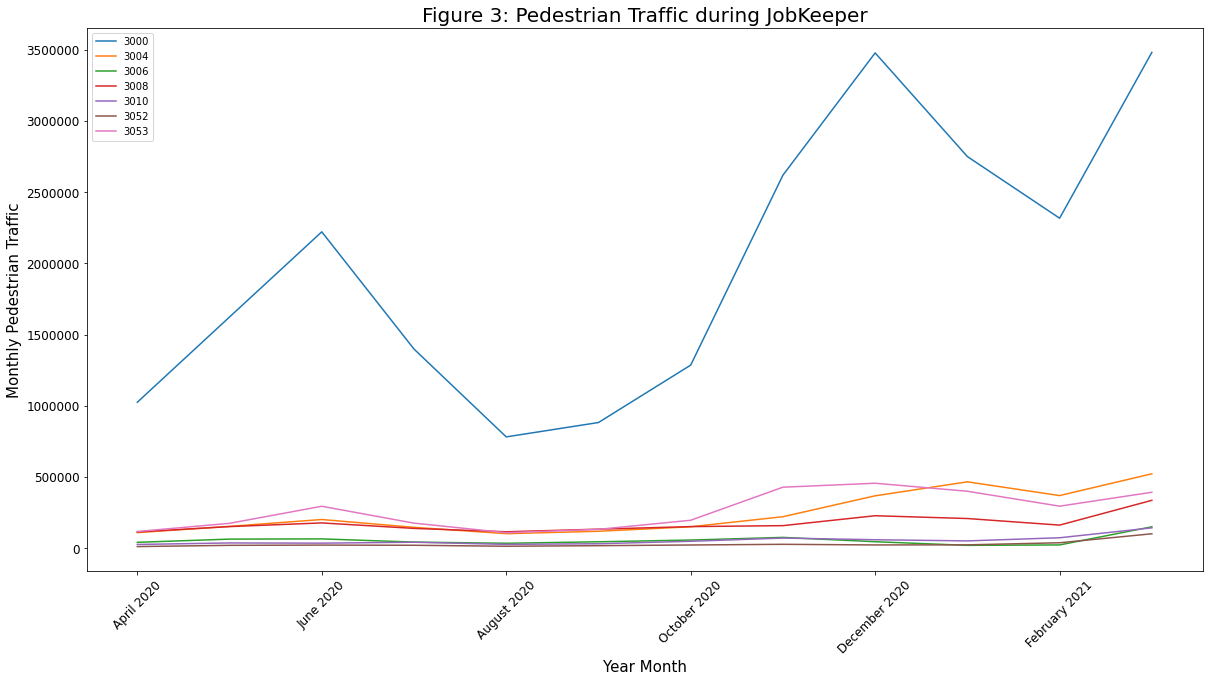

In [354]:
data = pd.read_csv("Melbourne City Council Data/Pedestrian_Activity_by_Postcode_per_month.csv")

date_list = ['April 2020', 'May 2020', 'June 2020', 'July 2020', 'August 2020', 'September 2020', 
             'October 2020', 'November 2020', 'December 2020', 'January 2021','February 2021', 'March 2021']

jobkeeper_pedestrian_data = data.loc[(data["Date"].isin(date_list))]

tick_spacing = 1

# Plot the data
jobkeeper_pedestrian_data_line_plot = jobkeeper_pedestrian_data.plot(x="Date",figsize = (20,10))

# Improve figure layout
jobkeeper_pedestrian_data_line_plot.set_xlabel(xlabel = "Year Month", size = 15)
jobkeeper_pedestrian_data_line_plot.set_ylabel(ylabel = "Monthly Pedestrian Traffic", size = 15)
jobkeeper_pedestrian_data_line_plot.set_title(("Figure 3: Pedestrian Traffic during JobKeeper") , size = 20)
jobkeeper_pedestrian_data_line_plot.xaxis.set_tick_params(labelsize = 12, rotation = 45)
jobkeeper_pedestrian_data_line_plot.yaxis.set_tick_params(labelsize = 12)

# # Fix tick values
jobkeeper_pedestrian_data_line_plot.ticklabel_format(axis='y', style='plain')

plt.pyplot.savefig("James Plots/Figure 3", dpi=400)

### Show sensor locations and pedestrian counts on Google Maps

In [360]:
pedestrian_location_sensor_data = pd.read_csv("Melbourne City Council Data/pedestrian_location_sensor_data.csv")

pedestrian_location_sensor_data

,sensor_id,April 2020,April 2021,August 2019,August 2020,August 2021,December 2019,December 2020,February 2020,February 2021,...,September 2020,sensor_description,sensor_name,status,direction_1,direction_2,latitude,longitude,Address,Postcode
0,3,127245.0,337429.0,981893.0,92864.0,105047.0,911297.0,351662.0,741496.0,104829.0,...,114151.0,Melbourne Central,Swa295_T,A,North,South,-37.811015,144.964295,"301 Swanston St, Melbourne VIC 3000, Australia",3000
1,4,130659.0,743653.0,1064689.0,97813.0,213065.0,1244392.0,796734.0,905988.0,456419.0,...,112765.0,Town Hall (West),Swa123_T,A,South,North,-37.814880,144.966088,"119 Capitol Arcade, Melbourne VIC 3000, Australia",3000
2,8,63684.0,112938.0,145010.0,68999.0,87220.0,146969.0,106220.0,135257.0,91493.0,...,82252.0,Webb Bridge,WebBN_T,A,North,South,-37.822935,144.947175,"3 Navigation Dr, Docklands VIC 3008, Australia",3008
3,11,26293.0,38862.0,31232.0,23613.0,28847.0,54072.0,42354.0,37750.0,30952.0,...,31762.0,Waterfront City,WatCit_T,A,East,West,-37.815650,144.939707,"84 Newquay Promenade, Docklands VIC 3008, Aust...",3008
4,27,34092.0,66367.0,110089.0,32909.0,52907.0,86444.0,64809.0,64092.0,51909.0,...,37112.0,QV Market-Peel St,Vic_T,A,East,West,-37.806069,144.956447,"165 Victoria St, Melbourne VIC 3004, Australia",3004
5,28,75387.0,563047.0,815103.0,69231.0,101841.0,732686.0,303045.0,701412.0,317626.0,...,81766.0,The Arts Centre,VAC_T,A,South,North,-37.821299,144.968793,"100 St Kilda Rd, Melbourne VIC 3004, Australia",3004
6,29,41299.0,121408.0,245551.0,34641.0,54388.0,279113.0,45554.0,190047.0,23016.0,...,45078.0,St Kilda Rd-Alexandra Gardens,AG_T,A,North,South,-37.819658,144.968635,"St Kilda Rd, Southbank VIC 3006, Australia",3006
7,30,47556.0,262827.0,409135.0,35315.0,61402.0,367248.0,220907.0,299653.0,156380.0,...,35982.0,Lonsdale St (South),Lon189_T,A,East,West,-37.811218,144.966568,"195 Lonsdale St, Melbourne VIC 3000, Australia",3000
8,31,42345.0,126872.0,165319.0,40863.0,42118.0,187154.0,159977.0,161819.0,96964.0,...,45843.0,Lygon St (West),Lyg161_T,A,South,North,-37.801697,144.966589,"169 Lygon St, Carlton VIC 3053, Australia",3053
9,34,20090.0,45860.0,136747.0,15199.0,24083.0,94563.0,25311.0,106629.0,28641.0,...,18816.0,Flinders St-Spark La,Fli32_T,A,East,West,-37.815380,144.974151,"1 Spring St, Melbourne VIC 3000, Australia",3000


In [365]:
# Configure gmaps
gmaps.configure(api_key = google_key)
fig = gmaps.figure()

# Using the template add the sensor location marks to the figure
info_box_template = """
<dl>
<dt>Sensor Name</dt><dd>{sensor_description}</dd>
<dt>Postcode</dt><dd>{Postcode}</dd>
<dt>April 2020 Pedestrian Count</dt><dd>{April 2020}</dd>
<dt>May 2020 Pedestrian Count</dt><dd>{May 2020}</dd>
<dt>June 2020 Pedestrian Count</dt><dd>{June 2020}</dd>
<dt>July 2020 Pedestrian Count</dt><dd>{July 2020}</dd>
<dt>August 2020 Pedestrian Count</dt><dd>{August 2020}</dd>
<dt>September 2020 Pedestrian Count</dt><dd>{September 2020}</dd>
<dt>October 2020 Pedestrian Count</dt><dd>{October 2020}</dd>
<dt>November 2020 Pedestrian Count</dt><dd>{November 2020}</dd>
<dt>December 2020 Pedestrian Count</dt><dd>{December 2020}</dd>
<dt>January 2021 Pedestrian Count</dt><dd>{January 2021}</dd>
<dt>February 2021 Pedestrian Count</dt><dd>{February 2021}</dd>
<dt>March 2021 Pedestrian Count</dt><dd>{March 2021}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
sensor_data_info = [info_box_template.format(**row) for index, row in pedestrian_location_sensor_data.iterrows()]

In [366]:
# Add Postcodes
with open('Postcodes.geojson') as f:
    geometry = json.load(f)
    
fig = gmaps.figure()
geojson_layer = gmaps.geojson_layer(geojson=geometry,fill_color="yellow",fill_opacity=0.2,stroke_color="blue")
fig.add_layer(geojson_layer)

# Add sensor locations
sensor_locations = pedestrian_location_sensor_data[["latitude", "longitude"]]
# Add the sensor markers to the postcode map
markers = gmaps.marker_layer(sensor_locations, info_box_content = sensor_data_info)
fig.add_layer(markers)

# Display the improved heat map
fig

Figure(layout=FigureLayout(height='420px'))